<a href="https://colab.research.google.com/github/gbwiersum/CLApartmentScraper/blob/main/CLScraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import random
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#!apt update
#!apt upgrade
!pip install selenium -q
!apt install chromium-chromedriver -y -q
import requests
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import datetime
import re

     |████████████████████████████████| 983 kB 14.8 MB/s 
     |████████████████████████████████| 138 kB 57.0 MB/s 
     |████████████████████████████████| 358 kB 58.6 MB/s 
     |████████████████████████████████| 4.0 MB 45.8 MB/s 
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 58 kB 5.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Defining basic methods,
Building the scraping engine. 


1.   Gets each page of listings
2.   For each page of listings, gets attributes and headline descriptions, sqft, rent and a url for the posting.



In [5]:
# Open a browser instance.
def start_browser(headless = True):
  chrome_options = webdriver.ChromeOptions()
  if headless:
    chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')
  webbrowser = webdriver.Chrome('chromedriver', options=chrome_options)
  if not headless:
    webbrowser.set_window_size(48, 32)
  return webbrowser


#Starts searching at a predefined URL
#Increments search for "results" number of pages, -1 for "all"
#Listings are iterated over and attributes are put into a dictionary
def get_listings(start_url, results=-1, cooldown=0):
  browser=start_browser()
  browser.get(start_url)
  result_dict = {}
  if results == -1:
    end = int(BeautifulSoup(browser.page_source).find('span', class_='totalcount').text)
  else:
    end = min([int(BeautifulSoup(browser.page_source).find('span', class_='totalcount').text), results])

  for n in range(0, end, 120):
      if n>0:
        browser.get((start_url+'?s='+str(n)))
      else:
        time.sleep(cooldown)
        browser.get(start_url)

      #Debug:
      #pagestart = BeautifulSoup(browser.page_source).find('span', class_='rangeFrom').text
      #pageend = BeautifulSoup(browser.page_source).find('span', class_='rangeTo').text
      #print("Processing: "+pagestart+" through " + pageend)
      #####

      listings = browser.find_elements(by=By.CLASS_NAME, value='result-info')
      for l in listings:
        html = l.get_attribute('innerHTML')
        attributes = get_listing_attributes(html)
        result_dict.update(attributes)

  final = pd.DataFrame.from_dict(result_dict, orient = 'index')
  final.columns = ['heading', 'url', 'rent', 'date posted', 'beds', 'sqft']
  return(final)

#Rewriting results page into dictionary format
#Takes html string of individual search result, returns dictionary with CL unique ID as index.
def get_listing_attributes(html):
    url = BeautifulSoup(html).a.get('href')

    try:
      price = BeautifulSoup(html).find('span', class_="result-price").text
      price = price.replace("$", "").replace(",", "")
      price = int(price)
    except:
      price = None
    
    date = BeautifulSoup(html).find('time', class_="result-date").get('datetime')

    try:
      bed = xml_getter(BeautifulSoup(html).find('span', class_="housing").text, after='br')
      bed = int(bed)
    except:
      bed=0

    try:
        sqft = xml_getter(BeautifulSoup(html).find('span', class_="housing").text, before="", after="ft2")
        sqft = int(sqft)
    except:
        sqft=None

    heading = BeautifulSoup(html).find('a', class_="result-title hdrlnk").text
    id = BeautifulSoup(html).find('a', class_='result-title hdrlnk').get('data-id')

    return({id:[heading, url, price, date, bed, sqft]})


#utility to pull variables out of xml data using leading and following tag.
#I refusue to learn regex and this is my workaround for that.
def xml_getter(text, before="", after=""):
  m = re.search(before+'(.+?)'+after, text)
  if m:
      found = m.group(1).strip()
      return(found)


#Scraping Results Page:

In [6]:
listingdf = get_listings('https://chicago.craigslist.org/search/apa', results=-1, cooldown=2)

Processing: 1 through 120
Processing: 121 through 240
Processing: 241 through 360
Processing: 361 through 480
Processing: 481 through 600
Processing: 601 through 720
Processing: 721 through 840
Processing: 841 through 960
Processing: 961 through 1080
Processing: 1081 through 1200
Processing: 1201 through 1320
Processing: 1321 through 1440
Processing: 1441 through 1560
Processing: 1561 through 1680
Processing: 1681 through 1800
Processing: 1801 through 1920
Processing: 1921 through 2040
Processing: 2041 through 2160
Processing: 2161 through 2280
Processing: 2281 through 2400
Processing: 2401 through 2520
Processing: 2521 through 2640
Processing: 2641 through 2760
Processing: 2761 through 2880
Processing: 2881 through 3000


In [7]:
browser = start_browser()
def pull_html(url, cooldown=0):
  try:
    browser.get(url)
    html = BeautifulSoup(browser.page_source)
    if html.header is None:
      return None
    elif 'blocked' in html:
      return None
    elif 'Page Not Found' in html.text:
      return "invalid url"
    else:
      time.sleep(cooldown)
      return html
  except:
    return None


def fetch_blank_listings(listingdf):
  #browser = start_browser()
  browser.get(listingdf['url'][0])
  tester = browser.page_source
  if len(tester)>1000:
    nans = listingdf[listingdf['html'].isna()]['url'].apply(lambda x: pull_html(x, cooldown=2))
    return(nans)
  else:
    print("failed to fetch first listing")
    print(BeautifulSoup(browser.page_source))

In [8]:
#Cleaning up listings that are improbably cheap or expensive
listingdf = listingdf[listingdf['rent']<10000]
listingdf = listingdf[listingdf['rent']>100]

# Analysis of Search Results:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


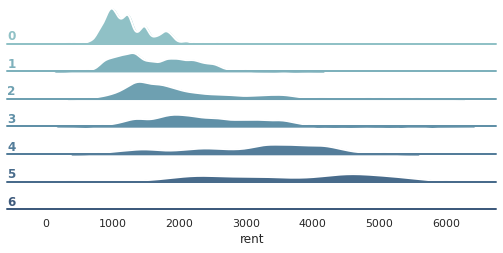

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(listingdf, row="beds", hue="beds", aspect=15, height=.5, palette=pal)
g.map(sns.kdeplot, "rent",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

g.map(sns.kdeplot, "rent", clip_on=False, color="w", lw=2, bw_adjust=.5)

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "rent")
g.figure.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

1.0866*X+713.0048
r=0.6848
p=0.0


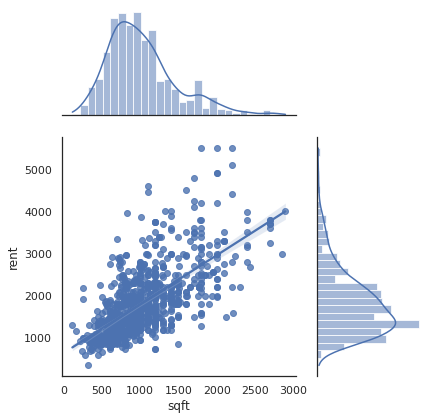

In [19]:
from scipy.stats import linregress
model = listingdf[listingdf['sqft']<3000]
f = sns.jointplot(x=model['sqft'], 
              y=model['rent'], 
              #hue = model['beds'],
              ratio=2,
              kind='reg',
              )

slope, intercept, r, p, se = linregress(x=listingdf[listingdf['sqft']>0]['sqft'], y=listingdf[listingdf['sqft']>0]['rent'])
print(str(slope.round(4))+"*X+"+str(intercept.round(4))+"\nr="+str(r.round(4))+"\np="+str(p.round(4)))

R^2 Score: 0.4512
Coefs: [47.48839289  1.07793065]
Standard Error: 584.2296


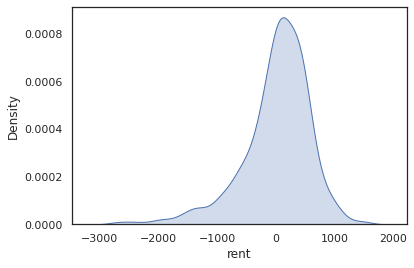

In [37]:
from sklearn import linear_model
y = model['rent']
x = model[['beds', 'sqft']]
multi_model = linear_model.LinearRegression()
multi_model.fit(x,y)
sns.kdeplot(multi_model.predict(x)-y, shade=True)
print('R^2 Score: '+str(multi_model.score(x,y).round(4)))
print("Coefs: "+str(multi_model.coef_))
print("Standard Error: "+str((multi_model.predict(x)-y).std().round(4)))

R^2 Score: 0.4496
Coefs: [1.1562934]
Standard Error: 585.123


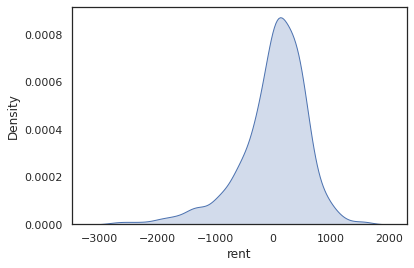

In [36]:
y = model['rent']
x = model[['sqft']]
multi_model = linear_model.LinearRegression()
multi_model.fit(x,y)
sns.kdeplot(multi_model.predict(x)-y, shade=True)
print('R^2 Score: '+str(multi_model.score(x,y).round(4)))
print("Coefs: "+str(multi_model.coef_))
print("Standard Error: "+str((multi_model.predict(x)-y).std().round(4)))

Number of bedrooms is not a significant factor over square-footage. Knowing the number of beds does not improve predictions of value, implying no meaningful relationship apart from communicating square-footage.

In [38]:
northside = get_listings('https://chicago.craigslist.org/search/chicago-il/apa?lat=41.9246&lon=-87.6801&search_distance=2.6')
southside = get_listings("https://chicago.craigslist.org/search/chicago-il/apa?lat=41.8128&lon=-87.6664&search_distance=4.3")
model['side']='S'
model = southside[['rent', 'beds', 'sqft']]
model['side']="S"
model = model.append(northside[['rent', 'beds', 'sqft']])
model['side'].fillna("N", inplace = True)
model

Processing: 1 through 120
Processing: 1 through 120
Processing: 1 through 120
Processing: 1 through 120
Processing: 1 through 120
Processing: 1 through 120
Processing: 1 through 120
Processing: 1 through 120
Processing: 1 through 120
Processing: 1 through 120
Processing: 1 through 120
Processing: 1 through 120
Processing: 1 through 120
Processing: 1 through 120
Processing: 1 through 120
Processing: 1 through 120


In [43]:
model[model['side']=='S']['rent'].describe()

count     123.000000
mean     1899.398374
std       784.808829
min       700.000000
25%      1300.000000
50%      1890.000000
75%      2315.000000
max      4950.000000
Name: rent, dtype: float64

In [45]:
model[model['side']=='N']['rent'].describe()

count     125.000000
mean     2156.944000
std       831.988604
min       975.000000
25%      1600.000000
50%      1925.000000
75%      2500.000000
max      5500.000000
Name: rent, dtype: float64

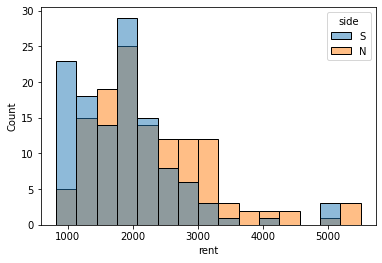

In [121]:
sns.histplot(model, x='rent', hue='side')

In [128]:
model['rent']=model['rent'].map(int)
model['ppsf'] = model['rent']/model['sqft']


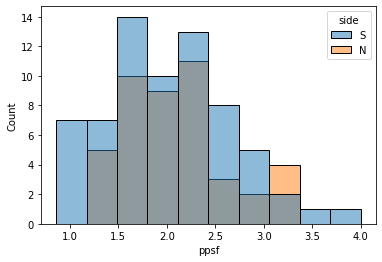

In [132]:
sns.histplot(model, x='ppsf', hue='side')

In [ ]:
#Fill in the blanks:
def fetch_blank_listings(listingdf):
  browser = start_browser()
  browser.get(listingdf['url'][0])
  tester = browser.page_source
  if len(tester)>1000:
    nans = listingdf[listingdf['html'].isna()]['url'].apply(lambda x: pull_html(x, cooldown=2))
    return(nans)
  else:
    print("failed to fetch first listing")
    print(BeautifulSoup(browser.page_source))

In [ ]:
#Pull listings html:
listingdf['html']=listingdf['url'][0:100].apply(lambda x: pull_html(x, cooldown=5))

In [21]:
def parse_listing_html(page_source):
  text=None
  attrvals = []
  if page_source is not None:
    try:
      text = str(page_source.find_all('p', class_='attrgroup')[0])
    except:
      text = None

  if text is not None:
    #baths, description body
    bedbath = BeautifulSoup(text).find('span', class_='shared-line-bubble').text
    baths = xml_getter(bedbath, before="/ ", after='Ba')
    body = str(page_source.find('section', id='postingbody').text).strip()

    try:
      #Latitude and longitude
      map_data = str(page_source.find_all('div', id='map')[0])
      lat = xml_getter(map_data, before='data-latitude="', after='" ')
      lon = xml_getter(map_data, before='data-longitude="', after='" ')
    except IndexError:
      lat=None
      lon=None
    attrvals.extend([baths,body,lat,lon])

    #Dogs/cats allowed, laundry situation:
    attrtext = page_source.find_all("p", class_='attrgroup')[1].text

    #We need to use a regex to pull the specific attributes
    park = re.search('\n(.+?)'+"park"+'(.+?)\n', attrtext)
    dog = re.search('\n'+'dog'+'(.+?)\n', attrtext)
    cat = re.search('\n'+'cat'+'(.+?)\n', attrtext)
    laundry = re.search('\n'+'laundry'+'(.+?)\n', attrtext)

    #Then we can pull them each out and add them to our list:
    attrs = [park, dog, cat, laundry]
    for n in attrs:
      if n is None:
        attrvals.append('None')
      else:
        attrvals.append(n.group(0).strip())

    return attrvals

  else:
    return None

#columns = ['baths', 'body', 'lat', 'lon', 'parking', 'dogs', 'cats', 'laundry']

In [ ]:

parsed = listingdf.apply(lambda x: parse_listing_html(x['html']), axis='columns', result_type='expand')
parsed.columns = ['baths', 'body', 'lat', 'lon', 'parking', 'dogs', 'cats', 'laundry']
listingdf = listingdf.join(parsed)
listingdf['Dpsf']=listingdf['rent']/listingdf['sqft']

def clean(heading):
  heading = heading.replace('QR Code Link to This Post\n\n\n', "")
  heading = heading.replace("\n", "")
  heading = re.sub('[^0-9a-zA-Z]+', " ", heading)
  heading = heading.lower()
  return(heading)

  listingdf['heading'].map(clean)

listingdf

In [ ]:
listingdf.dropna()

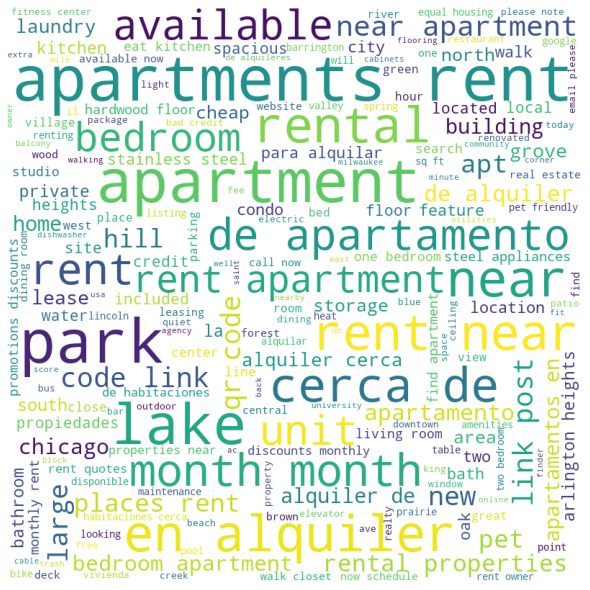

In [49]:
# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
 
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in listingdf.dropna().body:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [ ]:
heading_dummies = listingdf["heading"].str.get_dummies(sep=" ")
listingdf.set_index('key').join(heading_dummies.set_index('key'))

[nltk_data] Downloading package stopwords to /Users/grant/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


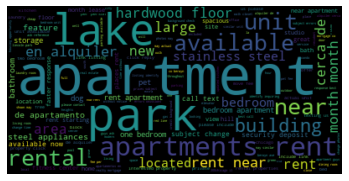

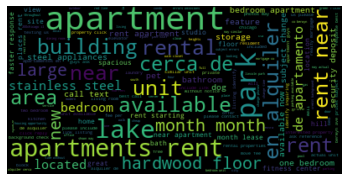

In [52]:
text = " ".join(clean(str(i)) for i in listingdf['body'].dropna())
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [78]:
#df=pd.read_csv('./CLScraped.csv')
dummy = listingdf[['rent','sqft', 'beds', 'baths', 'parking', 'lat', 'lon', 'dogs', 'cats', 'laundry']].dropna()
dummy['rent'] = dummy['rent'].apply(lambda x: (x-min(dummy['rent']))/(max(dummy['rent'])))
dummy['beds']=dummy['beds']/max(dummy['beds'])
dummy['dogs'].replace("None", 0, inplace=True)
dummy['dogs'].replace("dogs are OK - wooof", 1, inplace=True)
dummy['cats'].replace("None", 0, inplace=True)
dummy['cats'].replace('cats are OK - purrr', 1, inplace = True)
dummy['laundry'].replace('laundry in bldg', 1, inplace=True)
dummy["laundry"].replace('laundry on site', 1, inplace=True)
dummy['laundry'].replace("None", 0, inplace=True)
dummy[dummy['parking'].notnull()]['parking']=1
dummy['parking'].fillna(0, inplace=True)
dummy['sqft'].replace(0, None)
dummy['lat'] = dummy['lat'].map(float)
dummy['lon'] = dummy['lon'].map(float)
#########delete this later
dummy['baths']=dummy['baths'].apply(lambda x: float(x))
#########

dummy['baths']=dummy['baths']/max(dummy['baths'])

dummy = dummy.drop(columns=['sqft', 'parking'])

In [111]:
from sklearn import linear_model
y = listingdf['rent']
x = listingdf[['beds', 'baths', 'lat', 'lon', 'dogs', 'cats', 'laundry']]
multi_model = linear_model.LinearRegression()
multi_model.fit(x,y)
sns.histplot(multi_model.predict(x)-y)

ValueError: ignored

In [110]:
import numpy as np

multi_model.predict(np.array(x.iloc[0]).reshape(1,-1))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


array([0.02873673])